## DEEBO demo

In [14]:
import random
import numpy as np
import pandas as pd
import sklearn as skl
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import Image
from typing import Dict, Optional, Tuple, Union
from ax import Arm, ChoiceParameter, Models, ParameterType, SearchSpace, SimpleExperiment
from ax.plot.scatter import plot_fitted
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.utils.stats.statstools import agresti_coull_sem

In [15]:
def get_results(*components, short=False):
    """short only chooses normal reactants (reactant 1: aryl halide; reactant 2: bronic acid and boronate)

    :param components: TODO
    :param short:
    :return:
    """
    dic = {
        'ligand': 'Ligand_Short_Hand',
        'reactant1': 'Reactant_1_Name',
        'reactant2': 'Reactant_2_Name',
        'base': 'Reagent_1_Short_Hand',
        'solvent': 'Solvent_1_Short_Hand',
        }
    small_dic = {
        'reactant1': ['6-chloroquinoline', '6-Bromoquinoline', '6-triflatequinoline', '6-Iodoquinoline'],
        'reactant2': ['2a, Boronic Acid', '2b, Boronic Ester']
    }
    raw = pd.read_csv('../data/raw.csv')
    if short:
        raw = raw[raw[dic['reactant1']].isin(small_dic['reactant1'])]
        raw = raw[raw[dic['reactant2']].isin(small_dic['reactant2'])]

    for component in components:
        if component not in dic.keys():
            raise ValueError('Reaction component not found.')
    if len(components) == 1:
        df_col_name = dic[components[0]]
        w_yield = raw[[df_col_name, 'Product_Yield_PCT_Area_UV']]
        average = w_yield.groupby(df_col_name).mean()
        g = w_yield.groupby(df_col_name).cumcount()
        gb = w_yield.set_index([df_col_name, g]).unstack(fill_value=0).stack().groupby(level=0)
        results = np.array(gb.apply(lambda x: x.values.tolist()).tolist())  # this will list one row, output shape (num ligands, num exps, 1)
        names = list(gb.groups.keys())  # get ligand names from group by, preserve sequence
        results = results.reshape(len(names), -1)
        return names, average, results
    else:
        # TODO
        pass

### Suzuki dataset

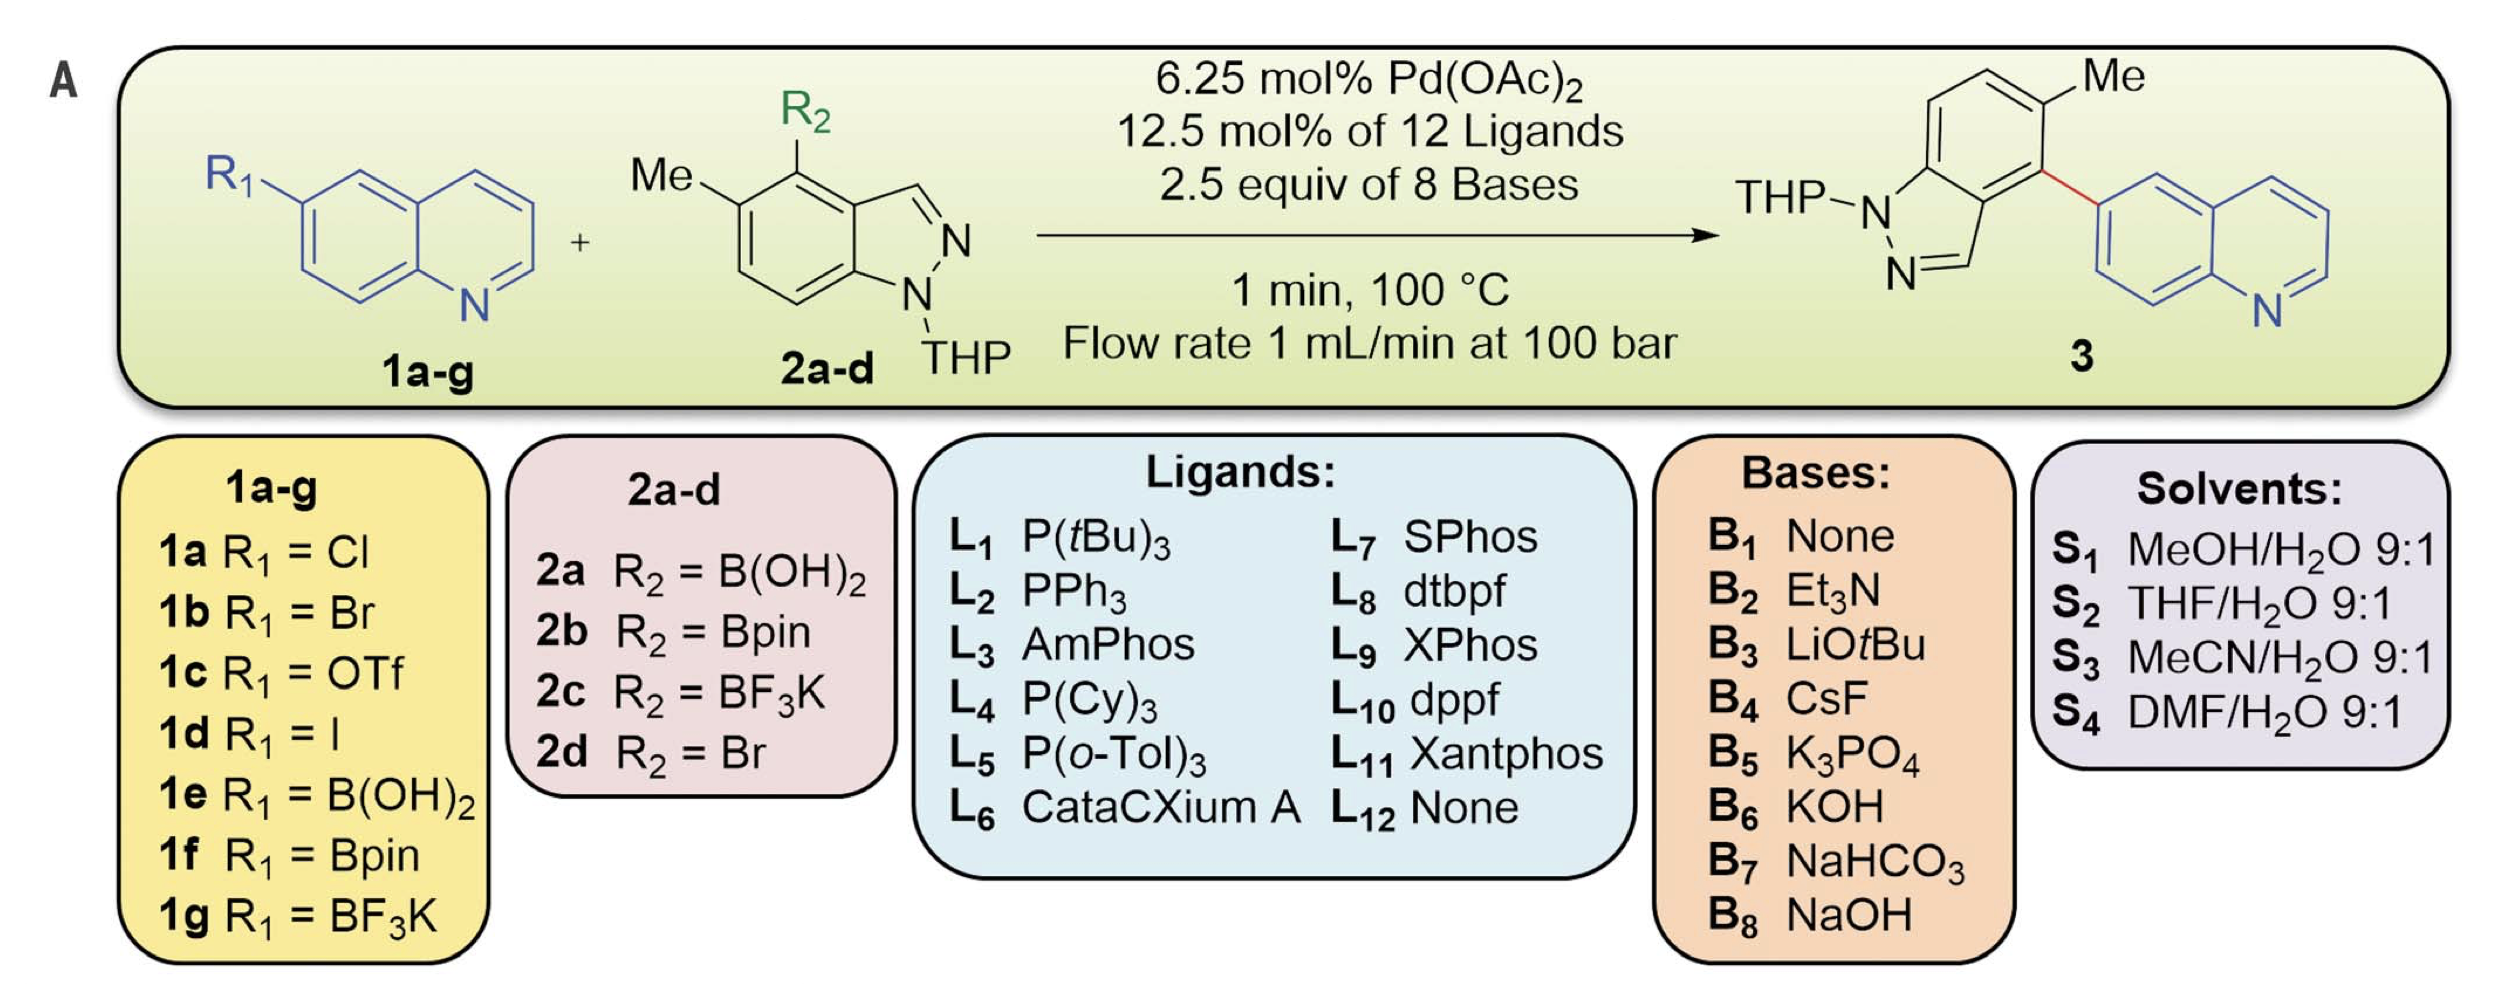

In [16]:
Image('resources/suzuki.png')

### Only picked 'normal' substrates for better distribution

In [11]:
names1, _, _ = get_results('reactant1', short=True)
names2, _, _ = get_results('reactant2', short=True)
names1, ' ', names2

(['6-Bromoquinoline',
  '6-Iodoquinoline',
  '6-chloroquinoline',
  '6-triflatequinoline'],
 ' ',
 ['2a, Boronic Acid', '2b, Boronic Ester'])

In [1]:
# simulate bandit optimization with Suzuki dataset
# using ligand as only parameter, one hot encode, randomly fetch reactivity data
# https://ax.dev/versions/latest/tutorials/factorial.html

init_notebook_plotting()

ligand_names, _, ligand_results = get_results('ligand')
ligand_results = ligand_results.reshape(len(ligand_names), -1)
print(ligand_results.shape)
# ['AmPhos', 'CataCXium A', 'None', 'P(Cy)3', 'P(Ph)3 ', 'P(o-Tol)3', 'P(tBu)3', 'SPhos', 'XPhos', 'Xantphos', 'dppf', 'dtbpf']


search_space = SearchSpace(
    parameters=[
        ChoiceParameter(
            name='ligand',
            parameter_type=ParameterType.STRING,
            values=ligand_names,
        )
    ]
)

ohe = skl.preprocessing.OneHotEncoder(categories=[par.values for par in search_space.parameters.values()],
                                      sparse=False)


def evaluation_function(parameterization: Dict[str, Optional[Union[str, bool, float]]], weight: Optional[float] = None):
    batch_size = 12
    noise_level = 0
    weight = weight if weight is not None else 1.0

    features = np.array(list(parameterization.values())).reshape(1, -1)
    encoded_features = np.array(ohe.fit_transform(features))

    # only 1D, select all available results first, then draw samples
    names, _, results = get_results('ligand')
    results = results.reshape(len(names), -1)
    results = ((results+1)*encoded_features.T)/100
    results = list(results.ravel()[np.flatnonzero(results)])

    # print('')
    # print('results: {0}'.format(results))

    # nn = np.random.binomial(batch_size, weight)
    # n = 1 if nn == 0 else n = nn
    # print('')
    # print('{0} samples drawn'.format(n))

    samples = random.sample(results, 5)
    mean = np.average(samples)
    sem = stats.sem(samples)

    return {'success_metric': (mean, sem)}


exp = SimpleExperiment(
    name="my_experiment",
    search_space=search_space,
    evaluation_function=evaluation_function,
    objective_name="success_metric",
)

# status_quo_ligand = random.choice(list(ligand_names))
# print('')
# print('status quo ligand: {0}'.format(status_quo_ligand))
# print('')
exp.status_quo = Arm(parameters={"ligand": 'None'})

factorial = Models.FACTORIAL(search_space=exp.search_space)
factorial_run = factorial.gen(n=-1)  # Number of arms to generate is derived from the search space.

trial = (
    exp.new_batch_trial(optimize_for_power=True)
    .add_generator_run(factorial_run, multiplier=1)
)

models = []
for i in range(5):
    print(f"Running trial {i+1}...")
    data = exp.eval_trial(trial)
    thompson = Models.THOMPSON(
        experiment=exp, data=data, min_weight=0.03
    )
    models.append(thompson)
    thompson_run = thompson.gen(n=-1)
    trial = exp.new_batch_trial(optimize_for_power=True).add_generator_run(thompson_run)

[INFO 04-04 00:54:59] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.


(12, 480)
Running trial 1...
Running trial 2...
Running trial 3...
Running trial 4...
Running trial 5...


In [2]:
render(plot_fitted(models[0], metric="success_metric", rel=False))

In [3]:
render(plot_fitted(models[-1], metric="success_metric", rel=False))

In [4]:
results = pd.DataFrame(
    [
        {"values": ",".join(arm.parameters.values()), "weight": weight}
        for arm, weight in trial.normalized_arm_weights().items()
    ]
)
print(results)

        values    weight
0      P(Ph)3   0.241969
1  CataCXium A  0.224450
2         None  0.533581


In [5]:
from ax.plot.bandit_rollout import plot_bandit_rollout
from ax.utils.notebook.plotting import render

render(plot_bandit_rollout(exp))

In [6]:
from ax.plot.marginal_effects import plot_marginal_effects
render(plot_marginal_effects(models[0], 'success_metric'))